In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import cartopy.crs as ccrs

### Reading in the data

### Airlines

As of January 2012, the OpenFlights Airlines Database contains 5888 airlines. Each entry contains the following information:

**Airline ID**	Unique OpenFlights identifier for this airline.

**Name**	Name of the airline.

**Alias**	Alias of the airline. For example, All Nippon Airways is commonly known as "ANA".

**IATA**	2-letter IATA code, if available.

**ICAO**	3-letter ICAO code, if available.

**Callsign**	Airline callsign.

**Country**	Country or territory where airport is located. See Countries to cross-reference to ISO 3166-1 codes.

**Active**	"Y" if the airline is or has until recently been operational, "N" if it is defunct. This field is not reliable: in particular, major airlines that stopped flying long ago, but have not had their IATA code reassigned (eg. Ansett/AN), will incorrectly show as "Y".
The data is UTF-8 encoded. The special value \N is used for "NULL" to indicate that no value is available, and is understood automatically by MySQL if imported.

Notes: Airlines with null codes/callsigns/countries generally represent user-added airlines. Since the data is intended primarily for current flights, defunct IATA codes are generally not included. For example, "Sabena" is not listed with a SN IATA code, since "SN" is presently used by its successor Brussels Airlines.

In [87]:
input_data = "DATA/airlines.txt"

headers = ['ID', 'Name', 'Alias', 'IATA', 'ICAO', 'Callsign', 'Country', 'Active']

airlines = pd.read_csv(input_data, sep=',', names=headers)
airlines = airlines.iloc[1:,]

In [88]:
airlines.shape

(6161, 8)

In [89]:
airlines.head()

,ID,Name,Alias,IATA,ICAO,Callsign,Country,Active
1,1,Private flight,\N,-,NaN,NaN,NaN,Y
2,2,135 Airways,\N,NaN,GNL,GENERAL,United States,N
3,3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
4,4,2 Sqn No 1 Elementary Flying Training School,\N,NaN,WYT,NaN,United Kingdom,N
5,5,213 Flight Unit,\N,NaN,TFU,NaN,Russia,N


### Airports

**Airport ID**	Unique OpenFlights identifier for this airport. 

**Name** Name of airport. May or may not contain the City name.

**City**	Main city served by airport. May be spelled differently from Name.

**Country**	Country or territory where airport is located. See Countries to cross-reference to ISO 3166-1 codes.

**IATA**	3-letter IATA code. Null if not assigned/unknown.

**ICAO**	4-letter ICAO code. Null if not assigned.

**Latitude**	Decimal degrees, usually to six significant digits. Negative is South, positive is North.

**Longitude**	Decimal degrees, usually to six significant digits. Negative is West, positive is East.

**Altitude**	In feet.

**Timezone**	Hours offset from UTC. Fractional hours are expressed as decimals, eg. India is 5.5.

**DST**	Daylight savings time. One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown). 

**Tz database timezone**	Timezone in "tz" (Olson) format, eg. "America/Los_Angeles".

**Type**	Type of the airport. Value "airport" for air terminals, "station" for train stations, "port" for ferry terminals and "unknown" if not known. In airports.csv, only type=airport is included.

**Source**	Source of this data. "OurAirports" for data sourced from OurAirports, "Legacy" for old data not matched to OurAirports (mostly DAFIF), "User" for unverified user contributions. In airports.csv, only source=OurAirports is included.
The data is UTF-8 encoded.

Note: Rules for daylight savings time change from year to year and from country to country. The current data is an approximation for 2009, built on a country level. Most airports in DST-less regions in countries that generally observe DST (eg. AL, HI in the USA, NT, QL in Australia, parts of Canada) are marked incorrectly.

In [90]:
input_data = "DATA/airports.txt"

headers = ['ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz database timezone', 'Type', 'Source']

airports = pd.read_csv(input_data, sep=',', names=headers)

In [91]:
#Remove nodes with missing coordinate values

airports = airports[airports.notnull()]

In [92]:
airports.shape

(7698, 14)

In [93]:
airports.head()

,ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database timezone,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998291,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001465,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.29600524902344,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.22000122070312,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [94]:
airports['Longitude'].isna().sum()

0

In [95]:
airports.dtypes #Longitude as object, needs to be changed to float

ID                        int64
Name                     object
City                     object
Country                  object
IATA                     object
ICAO                     object
Latitude                float64
Longitude                object
Altitude                  int64
Timezone                 object
DST                      object
Tz database timezone     object
Type                     object
Source                   object
dtype: object

In [96]:
#airports['Longitude'] = airports['Longitude'].astype(float)

#This causes an error: ValueError: could not convert string to float: '-a45.4259986877'
#Fixing this:
airports.loc[airports['Longitude'] == '-a45.4259986877', 'Longitude'] = '-45.4259986877'
airports['Longitude'] = airports['Longitude'].astype(float)

In [97]:
airports.loc[airports['Country'] == 'British Virgin Islands', 'Country'] = 'Virgin Islands'

### Routes

As of June 2014, the OpenFlights/Airline Route Mapper Route Database contains 67663 routes between 3321 airports on 548 airlines spanning the globe, as shown in the map above. Each entry contains the following information:

**Airline**	2-letter (IATA) or 3-letter (ICAO) code of the airline.

**Airline ID**	Unique OpenFlights identifier for airline (see Airline).

**Source airport**	3-letter (IATA) or 4-letter (ICAO) code of the source airport.

**Source airport ID**	Unique OpenFlights identifier for source airport (see Airport)

**Destination airport**	3-letter (IATA) or 4-letter (ICAO) code of the destination airport.

**Destination airport ID**	Unique OpenFlights identifier for destination airport (see Airport)

**Codeshare**	"Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.

**Stops**	Number of stops on this flight ("0" for direct)

**Equipment**	3-letter codes for plane type(s) generally used on this flight, separated by spaces
The data is UTF-8 encoded. The special value \N is used for "NULL" to indicate that no value is available, and is understood automatically by MySQL if imported.

Notes:
Routes are directional: if an airline operates services from A to B and from B to A, both A-B and B-A are listed separately.
Routes where one carrier operates both its own and codeshare flights are listed only once.

In [98]:
input_data = "DATA/routes.txt"

headers = ['Airline', 'Airline ID', 'Source', 'Source ID', 'Destination', 'Destination ID', 'Codeshare', 'Stops', 'Equipment']

routes = pd.read_csv(input_data, sep=',', names=headers)

In [99]:
routes.shape

(67663, 9)

In [100]:
routes.head()

,Airline,Airline ID,Source,Source ID,Destination,Destination ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


How many route endpoints use ICAO (4-letter) codes?

In [101]:
print(f"Number of sources with 4 letters: {routes['Source'].apply(lambda x: len(x) == 4).sum()}")
print(f"Number of destinations with 4 letters: {routes['Destination'].apply(lambda x: len(x) == 4).sum()}")

Number of sources with 4 letters: 0
Number of destinations with 4 letters: 0


#### Adding airplane capacity

Using the planes dataset from OpenFlights, plane capacity has been gathered by us using:https://github.com/atoff/OpenAircraftType/releases/tag/v0.3.0-alpha
as well as information from Wikipedia and ChatGPT.

The data will be added to the routes dataset, joined on plane IATA code, if there are multiple planes running on the route, we will use the average capacity of the plane.

In [102]:
routes = routes.reset_index() #to later join the split equipment columns by index

In [103]:
input_data = "DATA/planes_wt_count.csv"
planes_capacity = pd.read_csv(input_data, sep=',')
planes_capacity = planes_capacity[["iata","count"]]

In [104]:
split_cols = routes['Equipment'].str.split(' ', expand=True)
split_cols = split_cols.reset_index()
split_cols['plane_count'] = split_cols.iloc[:, 1:].count(axis=1)

melted = pd.melt(split_cols, id_vars=["index","plane_count"], value_vars=split_cols.columns[1:], value_name='iata').drop('variable', axis=1).dropna(subset=['iata'])
merged = melted.merge(planes_capacity, on='iata', how='left')
merged['count'].fillna(0, inplace=True)

summed_counts = merged.groupby(["index","plane_count"])['count'].sum().reset_index(name='total_capacity')
summed_counts['Avg_capacity'] = round(summed_counts['total_capacity'] / summed_counts['plane_count'],0)
summed_counts = summed_counts[["index","Avg_capacity"]]

routes = routes.merge(summed_counts, on='index', how='left')
routes=routes.drop("index",axis=1)

In [105]:
routes.head()

,Airline,Airline ID,Source,Source ID,Destination,Destination ID,Codeshare,Stops,Equipment,Avg_capacity
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2,50.0
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2,50.0
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2,50.0
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2,50.0
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2,50.0


### Country and World Region (+ Income Group)

United Nations Population Division. 
World Population Prospects: 2022 Revision, data ranging from 1960 to 2022.

https://data.worldbank.org/indicator/SP.POP.TOTL

Total population is based on the de facto definition of population, which counts all residents regardless of legal status or citizenship. The values shown are midyear estimates.

Income Group classification label is based on GDP per capita metric originating from World Bank.

In [106]:
population = pd.read_csv("DATA/population.csv", skiprows = 4)
population = population.loc[:,['Country Name', 'Country Code', '2014', '2022']] #Keeping only the relevant columns

In [107]:
population

,Country Name,Country Code,2014,2022
0,Aruba,ABW,103594.0,106445.0
1,Africa Eastern and Southern,AFE,583651101.0,720859132.0
2,Afghanistan,AFG,32716210.0,41128771.0
3,Africa Western and Central,AFW,397855507.0,490330870.0
4,Angola,AGO,27128337.0,35588987.0
...,...,...,...,...
261,Kosovo,XKX,1812771.0,1761985.0
262,"Yemen, Rep.",YEM,27753304.0,33696614.0
263,South Africa,ZAF,54729551.0,59893885.0
264,Zambia,ZMB,15737793.0,20017675.0


In [108]:
areas_and_inc_group = pd.read_csv("DATA/areas.csv")
areas_and_inc_group = areas_and_inc_group.loc[:,['Country Code', 'Region', 'IncomeGroup']]

In [109]:
areas_and_inc_group

,Country Code,Region,IncomeGroup
0,ABW,Latin America & Caribbean,High income
1,AFE,NaN,NaN
2,AFG,South Asia,Low income
3,AFW,NaN,NaN
4,AGO,Sub-Saharan Africa,Lower middle income
...,...,...,...
260,XKX,Europe & Central Asia,Upper middle income
261,YEM,Middle East & North Africa,Low income
262,ZAF,Sub-Saharan Africa,Upper middle income
263,ZMB,Sub-Saharan Africa,Lower middle income


Joining the tables

In [110]:
UN_data = population.merge(areas_and_inc_group, how = 'left', on = 'Country Code')

In [111]:
UN_data

,Country Name,Country Code,2014,2022,Region,IncomeGroup
0,Aruba,ABW,103594.0,106445.0,Latin America & Caribbean,High income
1,Africa Eastern and Southern,AFE,583651101.0,720859132.0,NaN,NaN
2,Afghanistan,AFG,32716210.0,41128771.0,South Asia,Low income
3,Africa Western and Central,AFW,397855507.0,490330870.0,NaN,NaN
4,Angola,AGO,27128337.0,35588987.0,Sub-Saharan Africa,Lower middle income
...,...,...,...,...,...,...
261,Kosovo,XKX,1812771.0,1761985.0,Europe & Central Asia,Upper middle income
262,"Yemen, Rep.",YEM,27753304.0,33696614.0,Middle East & North Africa,Low income
263,South Africa,ZAF,54729551.0,59893885.0,Sub-Saharan Africa,Upper middle income
264,Zambia,ZMB,15737793.0,20017675.0,Sub-Saharan Africa,Lower middle income


#### Modifying the UN data labels according to OpenFlights labels

Since OpenFlights data does not use country codes for airports, the data must be merged through country names and this holds potential for name mismatches.

In [112]:
#Unique country names of OpenFlights data
OF_countries = airports['Country'].unique()

#Unique country names of United Nations data
UN_countries = UN_data['Country Name'].unique()

In [113]:
#Dictionary to hold matches
matches = {}

for country in OF_countries:
    if country in UN_countries:
        matches[country] = country
    else:
        matches[country] = None  #No close match found
            
for k, v in matches.items():
    if v is None:
        print(f"No match found for {k}") #Print the mismatches
    #else:
        #print(f"Match found for {k}: {v}")

No match found for Guernsey
No match found for Jersey
No match found for Falkland Islands
No match found for Congo (Brazzaville)
No match found for Congo (Kinshasa)
No match found for Swaziland
No match found for Saint Helena
No match found for British Indian Ocean Territory
No match found for Mayotte
No match found for Reunion
No match found for Gambia
No match found for Cape Verde
No match found for Egypt
No match found for Saint Pierre and Miquelon
No match found for Czech Republic
No match found for Turkey
No match found for Macedonia
No match found for Slovakia
No match found for Bahamas
No match found for Cook Islands
No match found for Wallis and Futuna
No match found for Antarctica
No match found for Iran
No match found for West Bank
No match found for Syria
No match found for Midway Islands
No match found for Micronesia
No match found for Taiwan
No match found for South Korea
No match found for French Guiana
No match found for Venezuela
No match found for Martinique
No match f

Manually finding the OpenFlights country names that actually do exist in UN data:

* No data for Guernsey
* No data for Jersey
* No data for Falkland Islands
* **Congo (Brazzaville) is Congo, Rep.**
* **Congo (Kinshasa) is Congo, Dem. Rep.**
* **Swaziland is Eswatini**
* No data for Saint Helena
* No data for British Indian Ocean Territory
* No data for Mayotte
* No data for Reunion
* **Gambia is Gambia, The**
* **Cape Verde is Cabo Verde**
* **Egypt is Egypt, Arab Rep.**
* No data for Saint Pierre and Miquelon
* **Czech Republic is Czechia**
* **Turkey is Turkiye**
* **Macedonia is North Macedonia**
* **Slovakia is Slovak Republic**
* **Bahamas is Bahamas, The**
* No data for Cook Islands
* No data for Wallis and Futuna
* No data for Antarctica
* **Iran is Iran, Islamic Rep.**
* No data for West Bank
* **Syria is Syrian Arab Republic**
* No data for Midway Islands
* **Micronesia is Micronesia, Fed. Sts.**
* No data for Taiwan, seems to be categorised under China?
* **South Korea is Korea, Rep.**
* No data for French Guiana
* **Venezuela is Venezuela, RB**
* No data for Martinique
* No data for Guadeloupe
* **British Virgin Islands is Virgin Islands **
* **Saint Kitts and Nevis is St. Kitts and Nevis**
* **Saint Lucia is St. Lucia**
* No data for Netherlands Antilles
* No data for Anguilla
* **Saint Vincent and the Grenadines is St. Vincent and the Grenadines**
* **Kyrgystan is Kyrgyz Republic**
* **Russia is Russian Federation**
* **Hong Kong is Hong Kong SAR, China**
* **Laos is Lao PDR**
* **Macau is Macao SAR, China**
* **Vietnam is Viet Nam**
* **Burma is Myanmar**
* **Brunei is Brunei Darussalam**
* **East Timor is Timor-Leste**
* No data for Christmas Island
* No data for Norfolk Island
* **North Korea is Korea, Dem. People's Rep.**
* No data for Palestine
* **Yemen is Yemen, Rep.**
* No data for Monsterrat
* No data for Johnston Atoll
* No data for Western Sahara
* No data fro Niue
* No data for Cocos (Keeling) Islands
* No data for Svalbard
* No data for Wake Island

Now synchronise the names in the UN_data to match up better with OpenFlights data

In [114]:
country_name_map = {
    'Congo, Rep.': 'Congo (Brazzaville)',
    'Congo, Dem. Rep.': 'Congo (Kinshasa)',
    'Eswatini': 'Swaziland',
    'Gambia, The': 'Gambia',
    'Cabo Verde': 'Cape Verde',
    'Egypt, Arab Rep.': 'Egypt',
    'Czechia': 'Czech Republic',
    'Turkiye': 'Turkey',
    'North Macedonia': 'Macedonia',
    'Slovak Republic': 'Slovakia',
    'Bahamas, The': 'Bahamas',
    'Iran, Islamic Rep.': 'Iran',
    'Syrian Arab Republic': 'Syria',
    'Micronesia, Fed. Sts.': 'Micronesia',
    'Korea, Rep.': 'South Korea',
    'Venezuela, RB': 'Venezuela',
    'British Virgin Islands': 'Virgin Islands',
    'St. Kitts and Nevis': 'Saint Kitts and Nevis',
    'St. Lucia': 'Saint Lucia',
    'St. Vincent and the Grenadines': 'Saint Vincent and the Grenadines',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Russian Federation': 'Russia',
    'Hong Kong SAR, China': 'Hong Kong',
    'Lao PDR': 'Laos',
    'Macao SAR, China': 'Macau',
    'Viet Nam': 'Vietnam',
    'Myanmar': 'Burma',
    'Brunei Darussalam': 'Brunei',
    'Timor-Leste': 'East Timor',
    "Korea, Dem. People's Rep.": 'North Korea',
    'Yemen, Rep.': 'Yemen'
}


UN_data['OF Country Name'] = UN_data['Country Name'].map(country_name_map).fillna(UN_data['Country Name'])

Now remove all the rows that still do not have a match in the OpenFlights dataset

In [115]:
UN_data_filter = UN_data[UN_data['OF Country Name'].isin(OF_countries)]

In [116]:
UN_data_filter['Region'].unique()

array(['Latin America & Caribbean', 'South Asia', 'Sub-Saharan Africa',
       'Europe & Central Asia', 'Middle East & North Africa',
       'East Asia & Pacific', 'North America'], dtype=object)

### Visa requirements

Visa requirements can be a considerable travel option inhibitor and thus we have decided to include this information into our analysis. The visa requirements data originates from the following GitHub repository:

https://github.com/ilyankou/passport-index-dataset

This repository contains data spanning from 2019 to 2024, which is a crucial aspect to consider for our analysis. We will use the most recent data, specifically from January 5, 2024, to ensure accuracy. Although we don’t have population data for 2024 and the OpenFlights dataset we use dates back all the way to 2014 and our primary focus is on understanding the connectivity and functionality of global flight networks in various regions, especially in the context of natural disasters or epidemics, the use of older data could cause potential bias in our analysis. 

The reason being that from 2019 to 2023, the visa requirement data includes labels related to travel bans caused by COVID-19. However, incorporating these labels into our analysis would make it overly complicated. Therefore, we have chosen to exclude this layer of complexity for the time being. Nevertheless, analyzing the impact of these travel restrictions on network operations at different spatial levels during and outside of pandemic conditions could be a valuable area for future research.

In [117]:
visa_data = pd.read_csv("DATA/visa_20240105_iso3.csv")

visa_data.shape

(39601, 3)

In [118]:
visa_data.dtypes

Passport       object
Destination    object
Requirement    object
dtype: object

In [119]:
visa_data.head()

,Passport,Destination,Requirement
0,AFG,ALB,e-visa
1,AFG,DZA,visa required
2,AFG,AND,visa required
3,AFG,AGO,visa required
4,AFG,ATG,e-visa


In [120]:
visa_data['Requirement'].unique()

array(['e-visa', 'visa required', 'visa on arrival', '21', '90', '30',
       '-1', '180', '28', 'visa free', '360', '14', '60', '42', '15',
       '240', '120', 'no admission', '10', '45', '7', '31'], dtype=object)

The visa requirements data includes many different visa case options as shown in the table below.

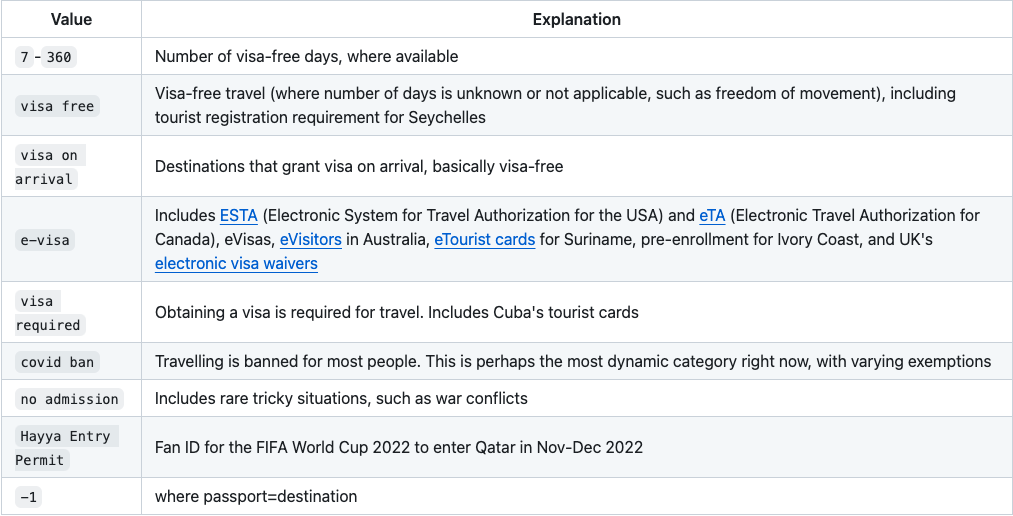

In [121]:
from IPython.display import Image
Image(filename='IMAGES/visa_table.png')

*Covid bans and FIFA World Cup labels are not relevant in our case*

We will simplify the classification schema as follows.

In [122]:
#Remapping function
def remap_requirement(req):
    if req.isdigit(): 
        return 'no visa' #1
    elif req == '-1': #-1 is not a digit for isdigit()
        return 'no visa'#1
    else:
        req_mapping = {
            'visa free': 'no visa', #1
            'visa on arrival': 'no visa', #1
            'e-visa': 'e-visa', #0.5
            'visa required': 'visa', #0.5
            'no admission': 'no entry' #0
        }
        return req_mapping.get(req, req)  #Default to original if no mapping found

In [123]:
visa_data['Req_remap'] = visa_data['Requirement'].apply(remap_requirement)

In [124]:
visa_data['Req_remap'].unique()

array(['e-visa', 'visa', 'no visa', 'no entry'], dtype=object)

In [125]:
visa_data.head()

,Passport,Destination,Requirement,Req_remap
0,AFG,ALB,e-visa,e-visa
1,AFG,DZA,visa required,visa
2,AFG,AND,visa required,visa
3,AFG,AGO,visa required,visa
4,AFG,ATG,e-visa,e-visa


#### Linking the visa information to the routes data

First we will link the visa information with the country names from the UN data table.

In [126]:
visa_country_names = visa_data.copy()

In [127]:
#Passport country name

visa_country_names = visa_country_names.merge(UN_data_filter[['OF Country Name', 'Country Code']], left_on = 'Passport', right_on = 'Country Code', how = 'left')

visa_country_names = visa_country_names.rename(columns={"OF Country Name": "Passport_name"})

visa_country_names = visa_country_names.drop(columns='Country Code')

In [128]:
#Destination country name

visa_country_names = visa_country_names.merge(UN_data_filter[['OF Country Name', 'Country Code']], left_on = 'Destination', right_on = 'Country Code', how = 'left')

visa_country_names = visa_country_names.rename(columns={"OF Country Name": "Destination_name"})

visa_country_names = visa_country_names.drop(columns='Country Code')

In [129]:
#These are the countries that were not present in UN data

visa_country_names[visa_country_names['Passport_name'].isna()]['Passport'].unique()

array(['AND', 'XKX', 'LIE', 'MCO', 'PSE', 'SMR', 'TWN', 'VAT'],
      dtype=object)

Now through the country names we connect the country ISO codes to the airports data.

In [130]:
airports = airports.merge(visa_country_names[['Passport', 'Passport_name']], left_on = 'Country', right_on = 'Passport_name', how = 'left')

#Dropping duplicates
airports = airports.drop_duplicates(subset=['ID'])

airports = airports.rename(columns={"Passport": "ISO"})

airports = airports.drop(columns='Passport_name')

In [131]:
airports = airports.merge(UN_data_filter[["OF Country Name",'Country Code','Region']], left_on ="Country", right_on= "OF Country Name",how="left")

In [132]:
airports = airports.drop(columns='OF Country Name')

Now we are able to connect the ISO codes of the airports to the endpoints in the routes dataset.

In [133]:
#Source country ISO

routes = routes.merge(airports[['IATA', 'ISO']], left_on = 'Source', right_on = 'IATA', how = 'left')

routes = routes.rename(columns={"ISO": "Source_ISO"})

routes = routes.drop(columns='IATA')

In [134]:
#Destination country ISO

routes = routes.merge(airports[['IATA', 'ISO']], left_on = 'Destination', right_on = 'IATA', how = 'left')

routes = routes.rename(columns={"ISO": "Destination_ISO"})

routes = routes.drop(columns='IATA')

In [135]:
routes.head()

,Airline,Airline ID,Source,Source ID,Destination,Destination ID,Codeshare,Stops,Equipment,Avg_capacity,Source_ISO,Destination_ISO
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2,50.0,RUS,RUS
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2,50.0,RUS,RUS
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2,50.0,RUS,RUS
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2,50.0,RUS,RUS
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2,50.0,RUS,RUS


In [136]:
#Routes with no endpoint ISO

print(f"{routes['Source_ISO'].isna().sum()} routes have no source country value")
print(f"{routes['Destination_ISO'].isna().sum()} routes have no destination country value")

1725 routes have no source country value
1731 routes have no destination country value


Now we can finally add the visa labels to the routes.

In [137]:
#Rename the columns in the visa dataframe for easier merge

visa_country_names = visa_country_names.rename(columns={'Passport': 'Source_ISO', 'Destination': 'Destination_ISO'})

In [138]:
routes = routes.merge(visa_country_names[['Source_ISO', 'Destination_ISO', 'Req_remap']], 
                            on=['Source_ISO', 'Destination_ISO'], 
                            how='left')

routes = routes.rename(columns={"Req_remap": "Visa"})

In [139]:
routes.head()

,Airline,Airline ID,Source,Source ID,Destination,Destination ID,Codeshare,Stops,Equipment,Avg_capacity,Source_ISO,Destination_ISO,Visa
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2,50.0,RUS,RUS,no visa
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2,50.0,RUS,RUS,no visa
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2,50.0,RUS,RUS,no visa
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2,50.0,RUS,RUS,no visa
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2,50.0,RUS,RUS,no visa


In [140]:
routes[routes["Visa"].isna()]

,Airline,Airline ID,Source,Source ID,Destination,Destination ID,Codeshare,Stops,Equipment,Avg_capacity,Source_ISO,Destination_ISO,Visa
170,2O,146,ADQ,3531,AOS,7167,NaN,0,BNI,9.0,USA,NaN,NaN
171,2O,146,ADQ,3531,KKB,7168,NaN,0,BNI,9.0,USA,NaN,NaN
173,2O,146,ADQ,3531,KOZ,7164,NaN,0,BNI,9.0,USA,NaN,NaN
174,2O,146,ADQ,3531,OLH,7163,NaN,0,BNI,9.0,USA,NaN,NaN
175,2O,146,AOS,7167,KZB,7176,NaN,0,BNI,9.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67543,ZK,2607,IGM,6132,PGA,4124,NaN,0,BE1,0.0,NaN,USA,NaN
67544,ZK,2607,LAX,3484,IGM,6132,NaN,0,BE1,0.0,USA,NaN,NaN
67555,ZK,2607,PGA,4124,IGM,6132,NaN,0,BE1,0.0,USA,NaN,NaN
67559,ZK,2607,PHX,3462,SVC,6135,NaN,0,BE1,0.0,USA,NaN,NaN


In [141]:
routes["Visa"].unique()

array(['no visa', 'visa', nan, 'e-visa', 'no entry'], dtype=object)

In [142]:
visa_mapping = {'no visa': 1, 'visa': 0, 'e-visa': 0} #since countries with no admission do not have routes anyway
routes["Visa"] = routes["Visa"].map(visa_mapping)

In [143]:
routes.head()

,Airline,Airline ID,Source,Source ID,Destination,Destination ID,Codeshare,Stops,Equipment,Avg_capacity,Source_ISO,Destination_ISO,Visa
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2,50.0,RUS,RUS,1.0
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2,50.0,RUS,RUS,1.0
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2,50.0,RUS,RUS,1.0
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2,50.0,RUS,RUS,1.0
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2,50.0,RUS,RUS,1.0


### Country geodata

We will also include geometries to the UN data to be able to plot the results later on.

Data originates from this GitHub repo: https://github.com/datasets/geo-countries

In [144]:
import geopandas as gpd

#Geodataframe
geo_df = gpd.read_file("DATA/countries.geojson")

In [145]:
geo_df.head()

,ADMIN,ISO_A3,ISO_A2,geometry
0,Aruba,ABW,AW,"MULTIPOLYGON (((-69.99694 12.57758, -69.93639 ..."
1,Afghanistan,AFG,AF,"MULTIPOLYGON (((71.04980 38.40866, 71.05714 38..."
2,Angola,AGO,AO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -..."
3,Anguilla,AIA,AI,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ..."
4,Albania,ALB,AL,"MULTIPOLYGON (((19.74777 42.57890, 19.74601 42..."


In [146]:
geo_df.shape

(255, 4)

Adding the geometries of UN countries to the UN dataset.

In [147]:
UN_data_geo = UN_data_filter.copy()

In [148]:
UN_data_geo = UN_data_geo.merge(geo_df[['ISO_A3', 'geometry']], left_on = 'Country Code', right_on = 'ISO_A3', how = 'left')

UN_data_geo = UN_data_geo.drop(columns='ISO_A3')

In [149]:
UN_data_geo.head()

,Country Name,Country Code,2014,2022,Region,IncomeGroup,OF Country Name,geometry
0,Aruba,ABW,103594.0,106445.0,Latin America & Caribbean,High income,Aruba,"MULTIPOLYGON (((-69.99694 12.57758, -69.93639 ..."
1,Afghanistan,AFG,32716210.0,41128771.0,South Asia,Low income,Afghanistan,"MULTIPOLYGON (((71.04980 38.40866, 71.05714 38..."
2,Angola,AGO,27128337.0,35588987.0,Sub-Saharan Africa,Lower middle income,Angola,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -..."
3,Albania,ALB,2889104.0,2777689.0,Europe & Central Asia,Upper middle income,Albania,"MULTIPOLYGON (((19.74777 42.57890, 19.74601 42..."
4,United Arab Emirates,ARE,8835951.0,9441129.0,Middle East & North Africa,High income,United Arab Emirates,"MULTIPOLYGON (((53.86305 24.23469, 53.88860 24..."


#### Adding population counts to routes

In [150]:
routes_population = routes.merge(UN_data_filter[['2014', '2022','Country Code']], how='left', left_on='Source_ISO', right_on='Country Code')

In [151]:
routes_population['Capacity_to_pop_14'] = routes_population['Avg_capacity'].clip(1) / routes_population['2014']
routes_population['Capacity_to_pop_22'] = routes_population['Avg_capacity'].clip(1) / routes_population['2022']

max_value_14 = routes_population['Capacity_to_pop_14'].max()
min_value_14 = routes_population['Capacity_to_pop_14'].min()
routes_population['Capacity_to_pop_14'] = (routes_population['Capacity_to_pop_14'] - min_value_14) / (max_value_14 - min_value_14)

max_value_22 = routes_population['Capacity_to_pop_22'].max()
min_value_22 = routes_population['Capacity_to_pop_22'].min()
routes_population['Capacity_to_pop_22'] = (routes_population['Capacity_to_pop_22'] - min_value_22) / (max_value_22 - min_value_22)

routes_population['Capacity_to_pop_14'] = routes_population['Capacity_to_pop_14'].astype(float)
routes_population['Capacity_to_pop_22'] = routes_population['Capacity_to_pop_22'].astype(float)

In [152]:
routes_population.head()

,Airline,Airline ID,Source,Source ID,Destination,Destination ID,Codeshare,Stops,Equipment,Avg_capacity,Source_ISO,Destination_ISO,Visa,2014,2022,Country Code,Capacity_to_pop_14,Capacity_to_pop_22
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2,50.0,RUS,RUS,1.0,143819667.0,144236933.0,RUS,0.000016,0.000017
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2,50.0,RUS,RUS,1.0,143819667.0,144236933.0,RUS,0.000016,0.000017
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2,50.0,RUS,RUS,1.0,143819667.0,144236933.0,RUS,0.000016,0.000017
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2,50.0,RUS,RUS,1.0,143819667.0,144236933.0,RUS,0.000016,0.000017
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2,50.0,RUS,RUS,1.0,143819667.0,144236933.0,RUS,0.000016,0.000017


In [153]:
routes_population["Capacity_to_pop_14_inv"] = 1/routes_population["Capacity_to_pop_14"]

In [154]:
routes_population["Capacity_to_pop_22_inv"] = 1/routes_population["Capacity_to_pop_22"]

In [155]:
routes_population["Visa_inv"] = abs(1-routes_population["Visa"])

In [156]:
routes_population

,Airline,Airline ID,Source,Source ID,Destination,Destination ID,Codeshare,Stops,Equipment,Avg_capacity,...,Destination_ISO,Visa,2014,2022,Country Code,Capacity_to_pop_14,Capacity_to_pop_22,Capacity_to_pop_14_inv,Capacity_to_pop_22_inv,Visa_inv
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2,50.0,...,RUS,1.0,143819667.0,144236933.0,RUS,0.000016,0.000017,60739.145236,60037.855017,0.0
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2,50.0,...,RUS,1.0,143819667.0,144236933.0,RUS,0.000016,0.000017,60739.145236,60037.855017,0.0
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2,50.0,...,RUS,1.0,143819667.0,144236933.0,RUS,0.000016,0.000017,60739.145236,60037.855017,0.0
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2,50.0,...,RUS,1.0,143819667.0,144236933.0,RUS,0.000016,0.000017,60739.145236,60037.855017,0.0
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2,50.0,...,RUS,1.0,143819667.0,144236933.0,RUS,0.000016,0.000017,60739.145236,60037.855017,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67658,ZL,4178,WYA,6334,ADL,3341,NaN,0,SF3,34.0,...,AUS,1.0,23475686.0,26005540.0,AUS,0.000069,0.000063,14556.831915,15894.804027,0.0
67659,ZM,19016,DME,4029,FRU,2912,NaN,0,734,188.0,...,KGZ,1.0,143819667.0,144236933.0,RUS,0.000062,0.000063,16129.151860,15943.643265,0.0
67660,ZM,19016,FRU,2912,DME,4029,NaN,0,734,188.0,...,RUS,1.0,5835500.0,6974900.0,KGZ,0.001529,0.001298,654.092104,770.593366,0.0
67661,ZM,19016,FRU,2912,OSS,2913,NaN,0,734,188.0,...,KGZ,1.0,5835500.0,6974900.0,KGZ,0.001529,0.001298,654.092104,770.593366,0.0


#### Adding region to airport

In [157]:
country_region_map = {
    'Guernsey': 'Europe & Central Asia',
    'Jersey': 'Europe & Central Asia',
    'Falkland Islands': 'Latin America & Caribbean',
    'Saint Helena': 'Sub-Saharan Africa',
    'British Indian Ocean Territory': 'East Asia & Pacific',
    'Mayotte': 'Sub-Saharan Africa',
    'Saint Pierre and Miquelon': 'North America',
    'Cook Islands': 'East Asia & Pacific',
    'Wallis and Futuna': 'East Asia & Pacific',
    'Taiwan': 'East Asia & Pacific',
    'French Guiana': 'Latin America & Caribbean',
    'Guadeloupe': 'Latin America & Caribbean',
    'Netherlands Antilles': 'Latin America & Caribbean',
    'Western Sahara': 'Middle East & North Africa',
    'Christmas Island': 'East Asia & Pacific',
    'Anguilla': 'Latin America & Caribbean',
    'Cocos (Keeling) Islands': 'East Asia & Pacific',
    'Reunion': 'Sub-Saharan Africa',
    'Martinique': 'Latin America & Caribbean',
    'Norfolk Island': 'East Asia & Pacific'
}

In [158]:
airports['Region'] = airports['Country'].map(country_region_map).fillna(airports['Region'])

In [159]:
airports.head()

,ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database timezone,Type,Source,ISO,Country Code,Region
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports,PNG,PNG,East Asia & Pacific
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports,PNG,PNG,East Asia & Pacific
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports,PNG,PNG,East Asia & Pacific
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports,PNG,PNG,East Asia & Pacific
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports,PNG,PNG,East Asia & Pacific


### Graph creation

**NB!** Needs to be updated since routes have been complimented with visa information.

In [160]:
import networkx as nx

In [161]:
G = nx.DiGraph()

for index, row in airports.iterrows():
    G.add_node(row['ID'], name=row['Name'], city=row['City'], country=row['Country'], region = row['Region'], iso=row['ISO'], iata=row['IATA'], icao=row['ICAO'], lat=row['Latitude'], lon=row['Longitude'])

for index, row in routes_population.iterrows():
    try:
        #Attempt to convert Source ID and Destination ID to integers
        source_id = int(row['Source ID'])
        dest_id = int(row['Destination ID'])
    except ValueError:
        #If conversion fails, skip this row
        print(f"Skipping invalid route from {row['Source ID']} to {row['Destination ID']}")
        continue

    #Retrieve source and destination node information
    if source_id in G.nodes and dest_id in G.nodes:
        source_node = G.nodes[source_id]
        dest_node = G.nodes[dest_id]

        #Check if both nodes have latitude and longitude information
        if 'lat' in source_node and 'lon' in source_node and 'lat' in dest_node and 'lon' in dest_node:
            
            G.add_edge(source_id, dest_id, 
                       airline=row['Airline ID'],
                       equipment=row['Equipment'], 
                       avg_capacity=row['Avg_capacity'],
                       visa=row['Visa'],
                       visa_inv = row['Visa_inv'],
                       cap_pop_14 = row['Capacity_to_pop_14'],
                       cap_pop_22 = row['Capacity_to_pop_22'],
                       cap_pop_14_inv = row['Capacity_to_pop_14_inv'],
                       cap_pop_22_inv = row['Capacity_to_pop_22_inv'],
                       source_lat=source_node['lat'], source_lon=source_node['lon'],
                       dest_lat=dest_node['lat'], dest_lon=dest_node['lon'])
        else:
            print(f"Missing location data for route from {source_id} to {dest_id}")
    else:
        print(f"One or both airports not found for route from {source_id} to {dest_id}")

Skipping invalid route from 4029 to \N
Skipping invalid route from \N to 4029
Skipping invalid route from 2937 to \N
Skipping invalid route from \N to 2937
One or both airports not found for route from 3531 to 7167
One or both airports not found for route from 3531 to 7168
One or both airports not found for route from 3531 to 7164
One or both airports not found for route from 3531 to 7163
One or both airports not found for route from 7167 to 7176
One or both airports not found for route from 7168 to 7173
One or both airports not found for route from 7164 to 7165
One or both airports not found for route from 7173 to 7172
One or both airports not found for route from 7144 to 7145
One or both airports not found for route from 7144 to 3808
One or both airports not found for route from 7145 to 7144
One or both airports not found for route from 7145 to 7147
One or both airports not found for route from 7145 to 3808
One or both airports not found for route from 7147 to 7145
One or both airpor

One or both airports not found for route from 8227 to 5454
Skipping invalid route from 8227 to \N
One or both airports not found for route from 8227 to 6463
One or both airports not found for route from 1957 to 5454
One or both airports not found for route from 1957 to 7287
One or both airports not found for route from 1957 to 7288
Skipping invalid route from 1957 to \N
One or both airports not found for route from 1957 to 6463
One or both airports not found for route from 5454 to 8227
One or both airports not found for route from 5454 to 1957
One or both airports not found for route from 5454 to 4279
One or both airports not found for route from 5454 to 6463
One or both airports not found for route from 7029 to 4279
One or both airports not found for route from 7287 to 1957
One or both airports not found for route from 7287 to 7288
One or both airports not found for route from 7287 to 6463
One or both airports not found for route from 7288 to 1957
One or both airports not found for ro

Skipping invalid route from \N to 2179
One or both airports not found for route from 6132 to 4124
One or both airports not found for route from 3484 to 6132
One or both airports not found for route from 6428 to 3391
One or both airports not found for route from 3406 to 8858
One or both airports not found for route from 3391 to 6428
One or both airports not found for route from 8858 to 3406
Skipping invalid route from 2188 to \N
Skipping invalid route from \N to 2188
One or both airports not found for route from 3404 to 8858
One or both airports not found for route from 6347 to 8858
One or both airports not found for route from 8858 to 3404
One or both airports not found for route from 8858 to 6347
Skipping invalid route from \N to 2191
Skipping invalid route from 2191 to \N
Skipping invalid route from 7642 to \N
One or both airports not found for route from 7642 to 4248
Skipping invalid route from 7642 to \N
Skipping invalid route from 7642 to \N
Skipping invalid route from 7642 to \N


One or both airports not found for route from 6428 to 3391
One or both airports not found for route from 6428 to 3374
One or both airports not found for route from 6428 to 3379
One or both airports not found for route from 3382 to 7528
One or both airports not found for route from 3406 to 6476
One or both airports not found for route from 3406 to 8858
One or both airports not found for route from 3391 to 6428
One or both airports not found for route from 3374 to 6428
One or both airports not found for route from 8858 to 3406
One or both airports not found for route from 7528 to 3382
One or both airports not found for route from 3379 to 6428
One or both airports not found for route from 1957 to 5454
One or both airports not found for route from 1957 to 7287
One or both airports not found for route from 1957 to 6463
One or both airports not found for route from 5454 to 1957
One or both airports not found for route from 5454 to 4279
Skipping invalid route from 7029 to \N
One or both airpo

One or both airports not found for route from 1701 to 5804
Skipping invalid route from 1701 to \N
Skipping invalid route from 1701 to \N
Skipping invalid route from \N to 1682
One or both airports not found for route from 5804 to 1701
Skipping invalid route from \N to 1701
Skipping invalid route from \N to 1701
Skipping invalid route from \N to 3316
Skipping invalid route from 3316 to \N
One or both airports not found for route from 5804 to 287
One or both airports not found for route from 287 to 5804
One or both airports not found for route from 6132 to 4124
One or both airports not found for route from 3484 to 6132
Skipping invalid route from \N to 9229
One or both airports not found for route from 7562 to 6169
Skipping invalid route from 9229 to \N
One or both airports not found for route from 6169 to 7562
Skipping invalid route from 2989 to \N
Skipping invalid route from \N to 2989
Skipping invalid route from \N to 2851
Skipping invalid route from 2851 to \N
One or both airports no

In [162]:
print(f'Nodes: {len(G.nodes)}')
print(f'Edges: {len(G.edges)}')

Nodes: 7698
Edges: 36907


#### Strongly connected components

In [163]:
strongly_connected_components = list(nx.strongly_connected_components(G))

for i, component in enumerate(strongly_connected_components, start=1):
      print(f"Component {i}: {component}, Length: {len(component)}")

Component 1: {7161}, Length: 1
Component 2: {7162}, Length: 1
Component 3: {7091}, Length: 1
Component 4: {7094}, Length: 1
Component 5: {6372}, Length: 1
Component 6: {7369}, Length: 1
Component 7: {2518}, Length: 1
Component 8: {8240}, Length: 1
Component 9: {8259}, Length: 1
Component 10: {7370}, Length: 1
Component 11: {2697}, Length: 1
Component 12: {4125}, Length: 1
Component 13: {4336}, Length: 1
Component 14: {1040}, Length: 1
Component 15: {11290}, Length: 1
Component 16: {7246}, Length: 1
Component 17: {7135}, Length: 1
Component 18: {7158}, Length: 1
Component 19: {1463}, Length: 1
Component 20: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 8199, 8200, 15, 16, 8209, 18, 21, 24, 8217, 27, 28, 29, 30, 31, 32, 33, 34, 8225, 8227, 37, 36, 8223, 40, 41, 8235, 45, 8237, 8238, 8239, 49, 50, 8242, 8244, 48, 54, 55, 8247, 56, 58, 60, 61, 62, 63, 8256, 65, 8258, 67, 68, 69, 70, 71, 72, 73, 8266, 75, 77, 78, 79, 80, 85, 87, 90, 91, 94, 99, 100, 105, 106, 108, 109, 111, 112, 113, 115, 116, 11

Keeping only the largest strongly connected component

In [164]:
largest_sc_component = max(nx.strongly_connected_components(G), key=len)

G_sc = G.subgraph(largest_sc_component)

In [165]:
print(f'Nodes: {len(G_sc.nodes)}')
print(f'Edges: {len(G_sc.edges)}')

Nodes: 3147
Edges: 36816


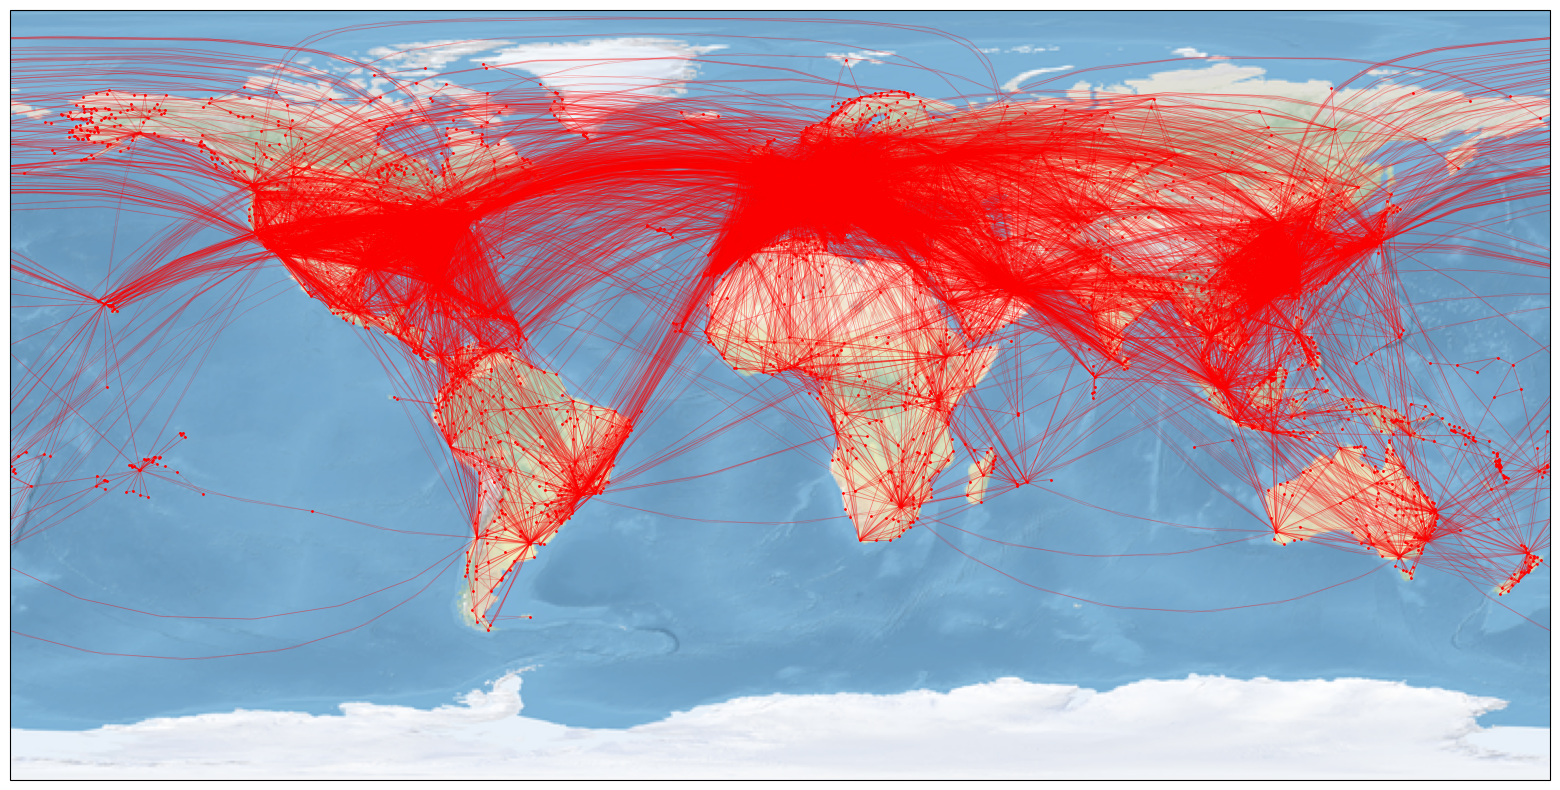

In [166]:
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()
ax.stock_img()  

#Airports
for node, attrs in G_sc.nodes(data=True):
    #Check if both 'lat' and 'lon' attributes exist
    if 'lon' in attrs and 'lat' in attrs:
        ax.plot(attrs['lon'], attrs['lat'], marker='o', color='red', markersize=1, transform=ccrs.Geodetic())


#Routes
for source, dest, attrs in G_sc.edges(data=True):
    source_node = G_sc.nodes[source]
    dest_node = G_sc.nodes[dest]
        
    source_coords = (source_node['lat'], source_node['lon'])
    dest_coords = (dest_node['lat'], dest_node['lon'])
                     
    ax.plot([source_coords[1], dest_coords[1]], [source_coords[0], dest_coords[0]], color='red', linewidth=0.5, alpha=0.25, transform=ccrs.Geodetic())

plt.show()

### Exporting the data

In [83]:
#Export the graph object
nx.write_graphml(G_sc,'EXPORTED_DATA/G_scc.graphml')

In [84]:
#Export the geodata
UN_data_geo = gpd.GeoDataFrame(UN_data_geo, geometry='geometry')
UN_data_geo.to_file('EXPORTED_DATA/UN_geodata.geojson', driver='GeoJSON')

In [85]:
#Export the graph nodes and edges as Dataframes
nodes_data = pd.DataFrame.from_dict(dict(G_sc.nodes(data=True)), orient='index') #of the largest strongly connected component

edges_list = []
for source, dest, attrs in G_sc.edges(data=True):
    edge_info = {'source': source, 'destination': dest}
    edge_info.update(attrs)
    edges_list.append(edge_info)
edges_data = pd.DataFrame(edges_list)

nodes_data.to_csv('EXPORTED_DATA/nodes.csv', index=True)
edges_data.to_csv('EXPORTED_DATA/edges.csv', index=None)